In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import semg_bss

# Configure log file
LOG_FILE = "semg_bss.log"
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', level=logging.INFO, filemode="w")

DATA_DIR = "/home/nihil/Scrivania/hyser_dataset"
FS_EMG = 2048  # sampling frequency
MAX_COMP = 100  # target number of components

SEED = 42

# Decomposition of sEMG Signals and Gesture Classification with SNNs
The aim of this project is to decompose a sEMG signal of a gesture, obtain the MUAPs, and then classify the gesture with a Spiking Neural Network (SNN). In particular, we'll train the decomposition model once on a training signal, which must be sufficiently informative about the gesture we want to recognize (*offline calibration*). Then, we'll reuse the decomposition model to transform new signals and classify them (*online analysis*).

## 1. Introduction to ICA-based Blind Source Separation
The original ICA formulation from [Hyvarinen et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) relies on instantaneous mixing:

$\mathbf{X} = \mathbf{A}\mathbf{S}$

where

- $\mathbf{X}$ is the $N_\text{recording} \times N_\text{samples}$ matrix of observables (i.e. the sEMG recording);
- $\mathbf{S}$ is the $N_\text{components} \times N_\text{samples}$ matrix of the original signals (i.e. the MUAPs);
- $\mathbf{A}$ is the $N_\text{recording} \times N_\text{components}$ mixing matrix.

The FastICA algorithm was developed to address this formulation.

However, since the muscle fibers act as a low-pass filter, the resulting sEMG signal is a convolutive mixture of the MUAPs ([Holobar et al.](https://ieeexplore.ieee.org/document/4291854)):

$x_i(k)=\sum_{l=0}^{L-1} \sum_{j=1}^N h_{ij}(l)s_j(k-l)+n_i(k);\;\;\;\;i=1,\dots,M$

namely the matrix of electrode recordings $\mathbf{X}$ is obtained by performing a 1D convolution between a mixing filter $\mathbf{H}$ with size $L$ and the actual spike trains $\mathbf{S}$.

[Thomas et al.](https://ieeexplore.ieee.org/document/1605245) adapted FastICA in order to address convolutive mixtures.

## 2. Hyser dataset
This dataset contains the sEMG recordings of 20 subjects, acquired while they were performing a certain task. In particular, the dataset is divided into 5 subsets, based on the task performed:

- **PR**: subjects were instructed to perform 34 hand gestures.
- **MVC**: subjects were instructed to perform their maximal voluntary isometric contraction.
- **1 DoF**: subjects were instructed to perform isometric contractions of each single finger.
- **N DoF**: subjects were instructed to perform isometric contractions of a combination of multiple fingers.
- **Random**: subjects were allowed to randomly perform isometric contractions of muscles corresponding to any combination of fingers with any force trajectory.

The sEMG data were collected using 4 arrays of 64 electrodes each (264 in total), with a sampling rate of 2048 Hz. The ground truth force trajectories of the five fingers were acquired using five separate sensor-amplifier pairs with a sampling rate of 100 Hz.

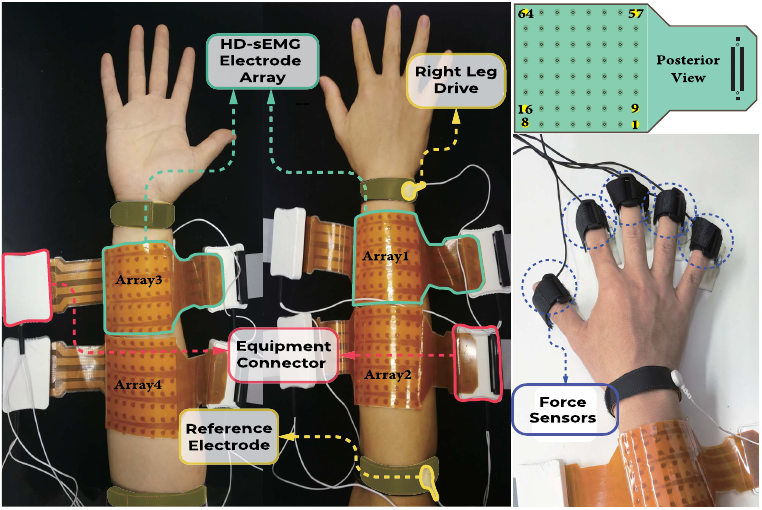

In particular, the first two arrays recorded the activity of the extensor muscle, whereas the remaining two arrays recorded the activity of the flexor muscle.

## 3. Decomposition

Let's focus on the PR dataset: for each subject, we have

- 2 recording sessions;
- 34 tasks (one per gesture);
- 2 trials;
- 3 dynamic tasks (1 s) and 1 maintenance task (4 s).

In particular, we're interested in the gestures "thumb extension" (the n. 1) and "index extension" (the n. 2).

For instance, let's visualize the first 15 channels of the sEMG signal for the 1st gesture (first subject, first session, first trial, maintenance).

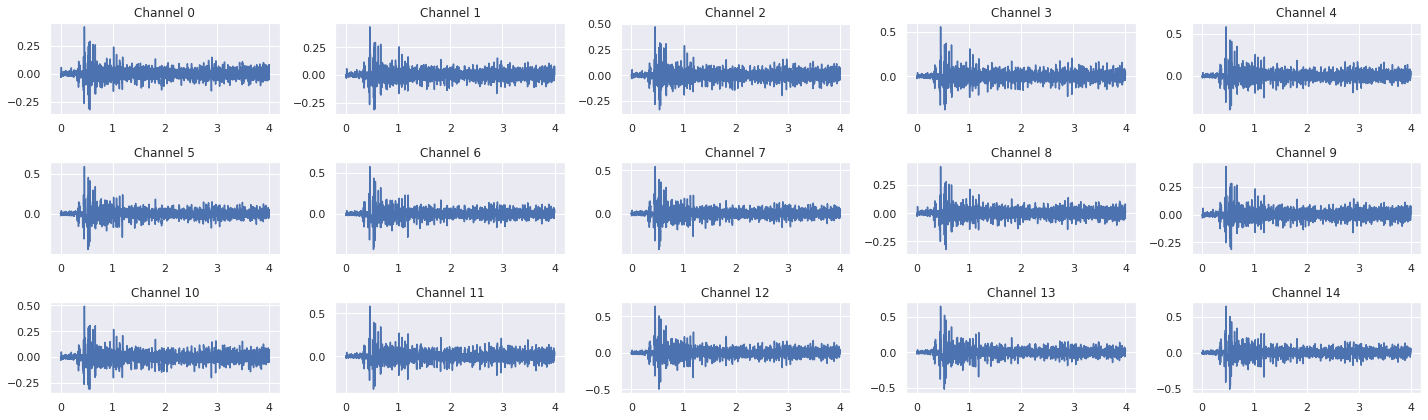

In [2]:
emg_pr1_train = semg_bss.hyser.load_pr(
    DATA_DIR,
    gesture=1,
    subject=1,
    session=1,
    task=1,
    trial=1,
    task_type="maintenance",
    sig_type="preprocess"
)

semg_bss.plot_signal(emg_pr1_train[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 6))

The first step is signal extension: since we have a convolutive mixture, we must extend the signal by adding delayed copies, resulting in $f_e \times M$ channels (where $M$ is the n. of channels in the original signal). In particular, we set $f_e=1000/M\approx4$.
Then, the extended signal is centered and whitened via eigenvalue decomposition.

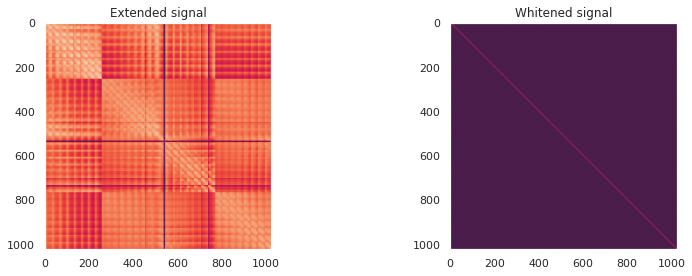

In [3]:
f_e = 4
emg_ext = semg_bss.preprocessing.extend_signal(emg_pr1_train, f_e)
emg_center = semg_bss.preprocessing.center_signal(emg_ext)
emg_white, white_mtx = semg_bss.preprocessing.whiten_signal(emg_center)

semg_bss.plot_correlation(array=[emg_ext, emg_white], title=["Extended signal", "Whitened signal"], n_cols=2, fig_size=(12, 4))

del emg_ext; del emg_center; del emg_white; del emg_pr1_train

The logic behind FastICA and source improvement is encapsulated inside the `EmgSeparator` class: let's create one using $100$ target components and $f_e=4$.

In [4]:
emg_separator = semg_bss.EmgSeparator(
    max_comp=MAX_COMP,
    fs=FS_EMG,
    f_e=f_e,
    seed=SEED
)

### Training
Let's include in the training data 2 maintenance sEMG signals, one per gesture.

In [5]:
emg_pr_train = []
for gesture in (1, 2):
    emg_pr_train.append(
        semg_bss.hyser.load_pr(
            DATA_DIR,
            gesture=gesture,
            subject=1,
            session=1,
            task=1,
            trial=1,
            task_type="maintenance",
            sig_type="preprocess"
        )
    )
emg_pr_train = np.stack(emg_pr_train, axis=0)
print("Shape of training data:", emg_pr_train.shape)

Shape of training data: (2, 256, 8192)


Let's train the `EmgSeparator` instance.

Extracted 34 MUs.


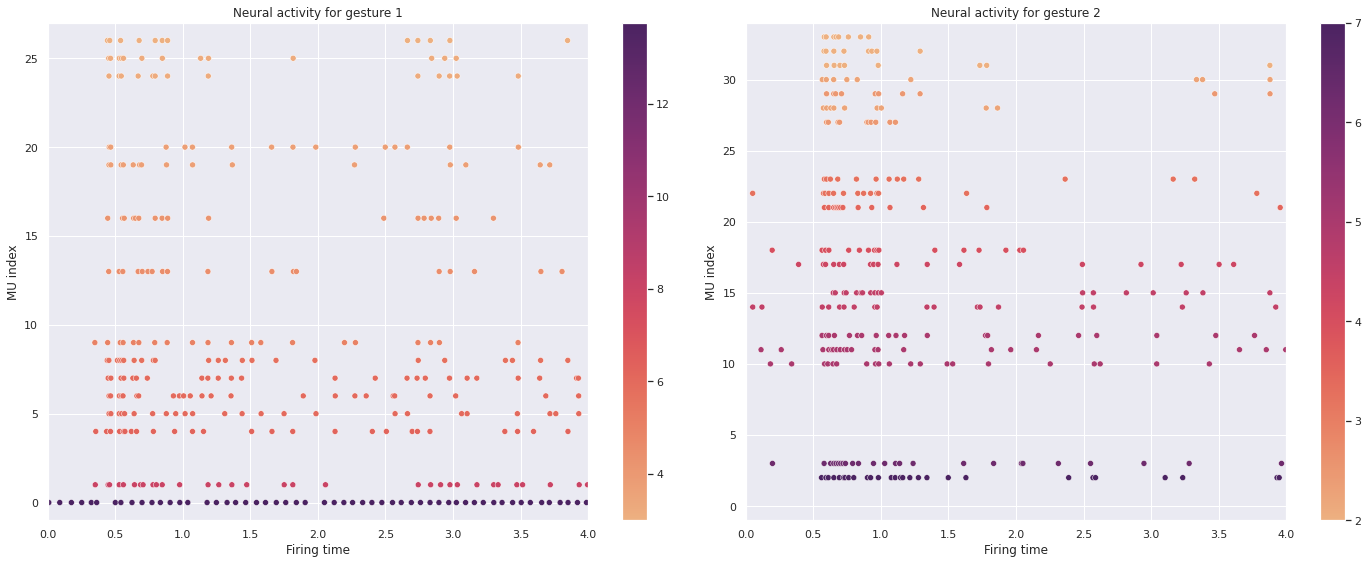

In [6]:
# Train instance on the given signal
emg_separator.fit(emg_pr_train)
print(f"Extracted {emg_separator.n_mu} MUs.")
(firings_pr1_train, firings_pr2_train) = emg_separator.transform(emg_pr_train)
# Plot it
semg_bss.raster_plot([firings_pr1_train, firings_pr2_train], title=["Neural activity for gesture 1", "Neural activity for gesture 2"], sig_len=4, n_cols=2, fig_size=(20, 8))

Let's plot the histogram of firing events: as we can see, the distribution of spikes reflects the original sEMG signal.

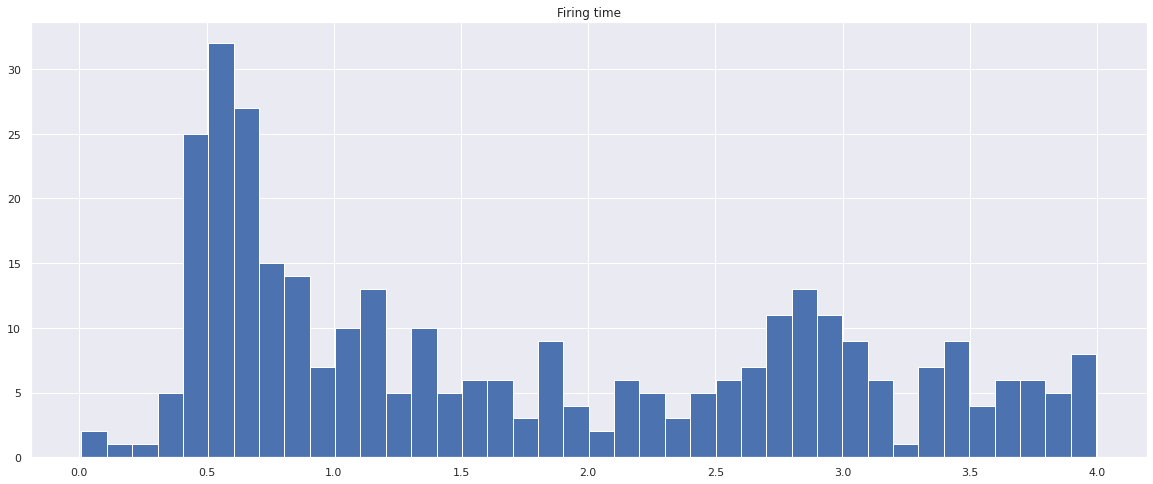

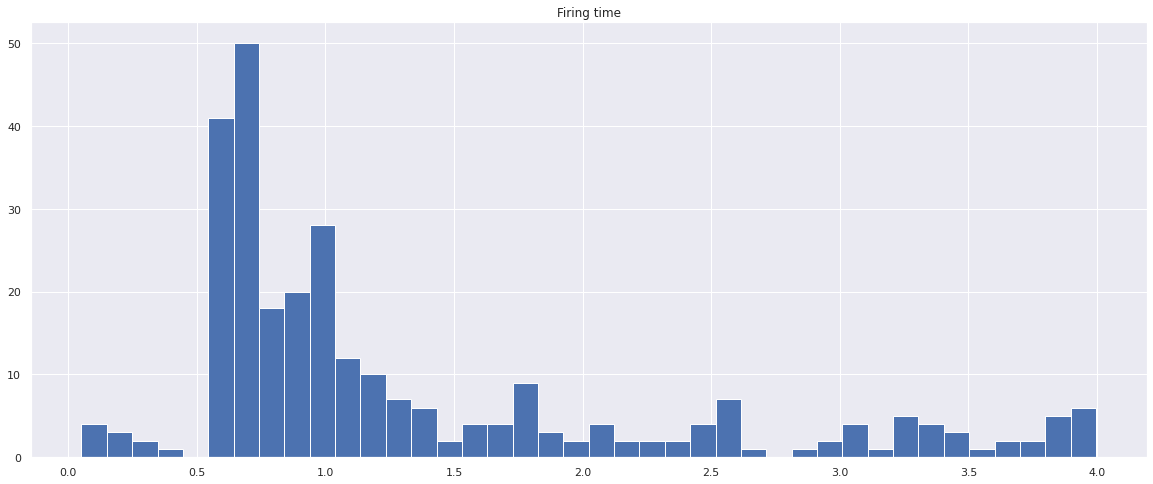

In [7]:
firings_pr1_train.hist(column="Firing time", bins=40, figsize=(20, 8))
firings_pr2_train.hist(column="Firing time", bins=40, figsize=(20, 8));

### Test
Let's now load the dynamic signals for the two gestures.

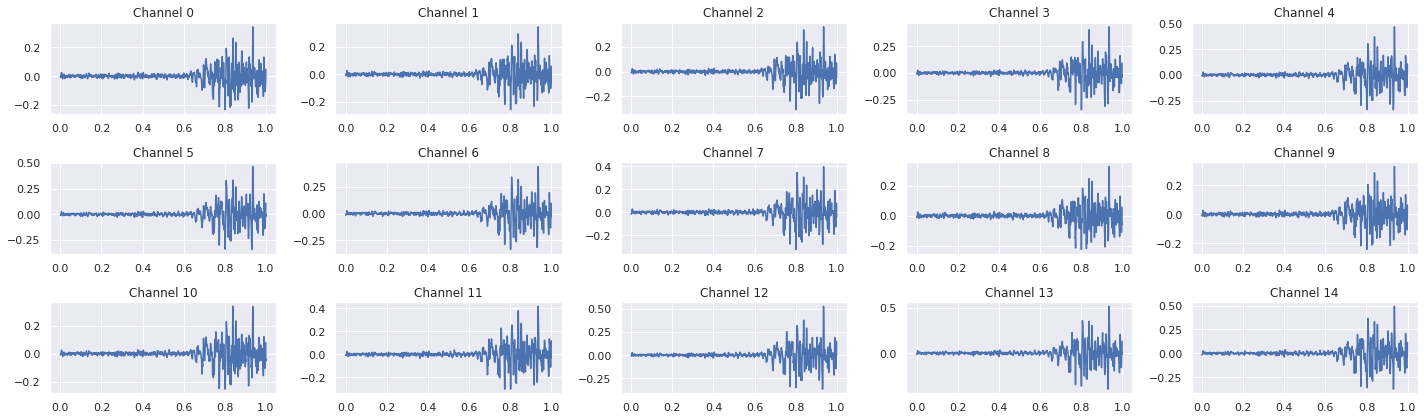

In [8]:
emg_pr1_test = semg_bss.hyser.load_pr(
    DATA_DIR,
    task_type="dynamic",
    gesture=1,
    subject=1,
    session=1,
    task=1,
    trial=1,
    sig_type="preprocess"
)
semg_bss.plot_signal(emg_pr1_test[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 6))

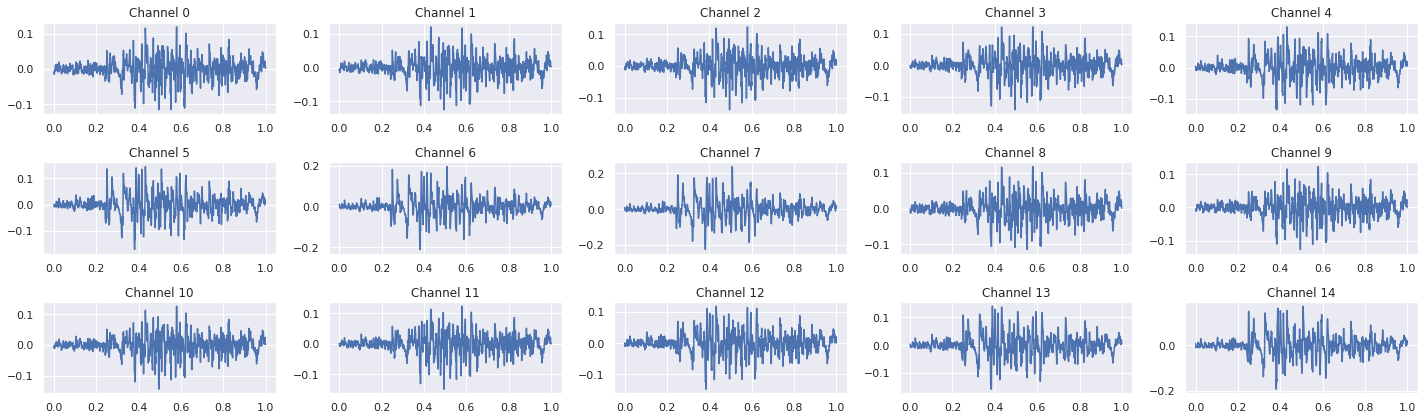

In [9]:
emg_pr2_test = semg_bss.hyser.load_pr(
    DATA_DIR,
    task_type="dynamic",
    gesture=2,
    subject=1,
    session=1,
    task=1,
    trial=1,
    sig_type="preprocess"
)
semg_bss.plot_signal(emg_pr2_test[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 6))

Let's decompose the two dynamic signals with the model trained previously.

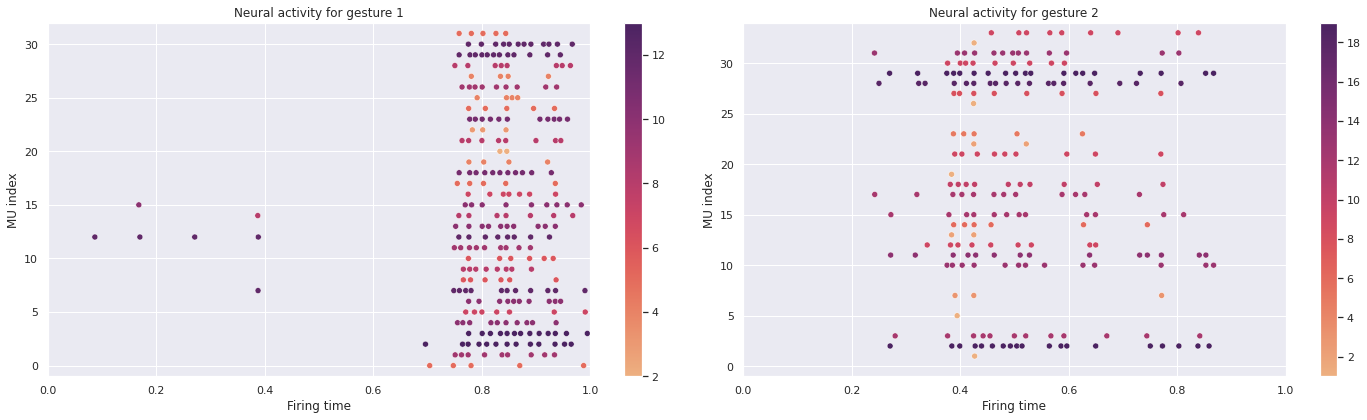

In [13]:
firings_pr1_test = emg_separator.transform(emg_pr1_test)[0]
firings_pr2_test = emg_separator.transform(emg_pr2_test)[0]

semg_bss.raster_plot(
    firings=[firings_pr1_test, firings_pr2_test],
    title=["Neural activity for gesture 1", "Neural activity for gesture 2"],
    sig_len=1,
    n_cols=2,
    fig_size=(20, 6)
)

## 4. Classification
Let's define a simple 2-layer SNN with 2 output neurons, one per gesture.

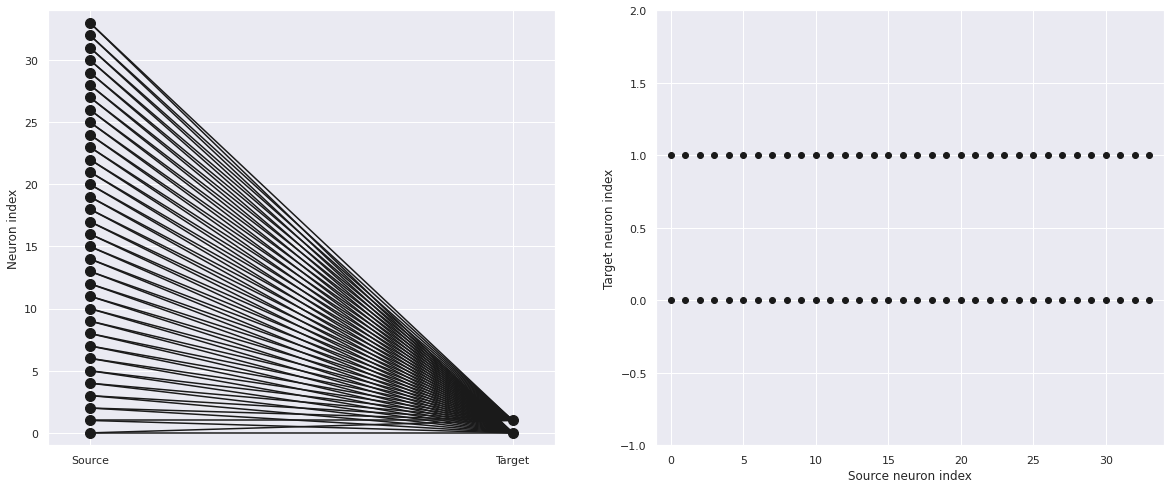

In [17]:
import itertools

from brian2 import *

n_in = emg_separator.n_mu  # number of input neurons
n_out = 2  # number of output neurons

# Define connectivity
# conn = [(i, 0) for i in firings_pr1_test["MU index"]]
# conn.extend([(i, 1) for i in firings_pr2_dyn["MU index"]])
conn = list(itertools.product(range(n_in), range(n_out)))
# sparse_deg = 0.5  # keep only 50% of connections
# rng = np.random.default_rng(SEED)
# conn = rng.choice(conn, int(len(conn) * sparse_deg))
conn_i, conn_j = zip(*conn)

# Create network
snn = Network()

# Define constants
V_rest = -74 * mV  # rest membrane potential (-74 mV)
tau = 20 * ms  # time constant of the neuron (20 ms)
V_th = -54 * mV  # threshold membrane potential (-54 mV)
V_reset = -60 * mV  # membrane potential after reset (-60 mV)
E_ex = 0 * mV  # potential of excitatory synapse (0 mV)
tau_ex = 5 * ms  # time constant of the excitatory synapse (5 ms)
g_max = 0.015  # maximum conductance (0.015)
taupre = 20 * ms  # time constant of presynaptic interspike interval (20 ms)
taupost = 20 * ms  # time constant of postsynaptic interspike interval (20 ms)
Apre = 0.005  # maximum amount of presynaptic modification (0.005)
Apost = Apre * taupre / taupost * 1.05  # maximum amount of postsynaptic modification

# Define differential equations
eqs = """
    dV/dt = (V_rest - V + g_ex * (E_ex - V)) / tau : volt (unless refractory)
    dg_ex/dt = -g_ex / tau_ex : 1
"""
eqs_syn = """
    w : 1
    dapre/dt = -apre / taupre : 1 (event-driven)
    dapost/dt = -apost / taupost : 1 (event-driven)
"""
eqs_pre = """
    g_ex += w
    apre += Apre
    w = clip(w + apost * g_max, 0, g_max)
"""
eqs_post = """
    apost -= Apost
    w = clip(w + apre * g_max, 0, g_max)
"""

# Define layers
n0 = SpikeGeneratorGroup(n_in, [0], [0] * second)
n1 = NeuronGroup(n_out, eqs, threshold="V > V_th", reset="V = V_reset", refractory=5 * ms, method="euler")

# Define synapse
syn = Synapses(n0, n1, model=eqs_syn, on_pre=eqs_pre, on_post=eqs_post, method="linear")
syn.connect(i=conn_i, j=conn_j)
syn.w = "rand() * g_max"

# Define spike monitor
monitor0 = SpikeMonitor(n0)
monitor1 = SpikeMonitor(n1)
monitor2 = StateMonitor(syn, "w", record=True)
monitor3 = StateMonitor(n1, "V", record=True)

# Add everything to the network
snn.add(n0)
snn.add(n1)
snn.add(syn)
snn.add(monitor0)
snn.add(monitor1)
snn.add(monitor2)
snn.add(monitor3)

semg_bss.plot_connectivity(syn, fig_size=(20, 8))

In [16]:
k = 0
for gesture in (1, 2):
    for trial in (1, 2):
        for task in (1, 2, 3):
            # Read EMG signal
            emg_pr_dyn = semg_bss.hyser.load_pr(
                DATA_DIR,
                task_type="dynamic",
                gesture=gesture,
                subject=1,
                session=1,
                task=task,
                trial=trial,
                sig_type="preprocess"
            )
            # Extract MUAPTs
            firings_dyn = emg_separator.transform(emg_pr_dyn)
            # Run simulation
            n0.set_spikes(firings_dyn["MU index"].values, (firings_dyn["Firing time"].values + k) * second)
            snn.run(1 * second)
            # Increment k
            k += 1
w = syn.w

plt.figure(figsize=(20, 12))

plt.subplot(221)
plt.title("Input spikes")
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.plot(monitor0.t / second, monitor0.i, ".k")

plt.subplot(222)
plt.title("Output spikes")
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.plot(monitor1.t / second, monitor1.i, ".k")

plt.subplot(223)
plt.title("Synapses weights")
plt.xlabel("Time (s)")
plt.ylabel("w / g_max")
plt.plot(monitor2.t / second, monitor2.w.T / g_max)

plt.subplot(224)
plt.title("Membrane potential")
plt.xlabel("Time (s)")
plt.ylabel("V")
plt.plot(monitor3.t / second, monitor3.V[0], label="Neuron 0")
plt.plot(monitor3.t / second, monitor3.V[1], label="Neuron 1")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

NameError: name 'n0' is not defined

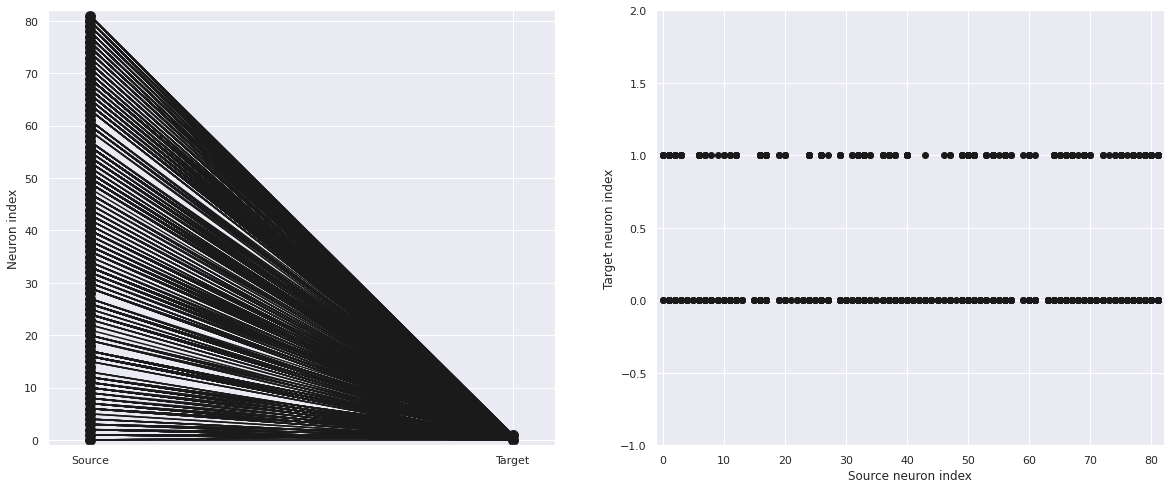

In [72]:
# Create network
snn = Network()

# Define layers
n0 = SpikeGeneratorGroup(n_in, [0], [0] * second)
n1 = NeuronGroup(n_out, eqs, threshold="V > V_th", reset="V = V_reset", refractory=5 * ms, method="euler")

# Define synapse
syn = Synapses(n0, n1, model="w : 1", on_pre="g_ex += w", method="linear")
syn.connect(i=conn_i, j=conn_j)
syn.w = w

# Define spike monitor
monitor0 = SpikeMonitor(n0)
monitor1 = SpikeMonitor(n1)
monitor2 = StateMonitor(syn, "w", record=True)
monitor3 = StateMonitor(n1, "V", record=True)

# Add everything to the network
snn.add(n0)
snn.add(n1)
snn.add(syn)
snn.add(monitor0)
snn.add(monitor1)
snn.add(monitor2)
snn.add(monitor3)

semg_bss.plot_connectivity(syn, fig_size=(20, 8))

Neuron0 spiked 6 times.
Neuron1 spiked 4 times.


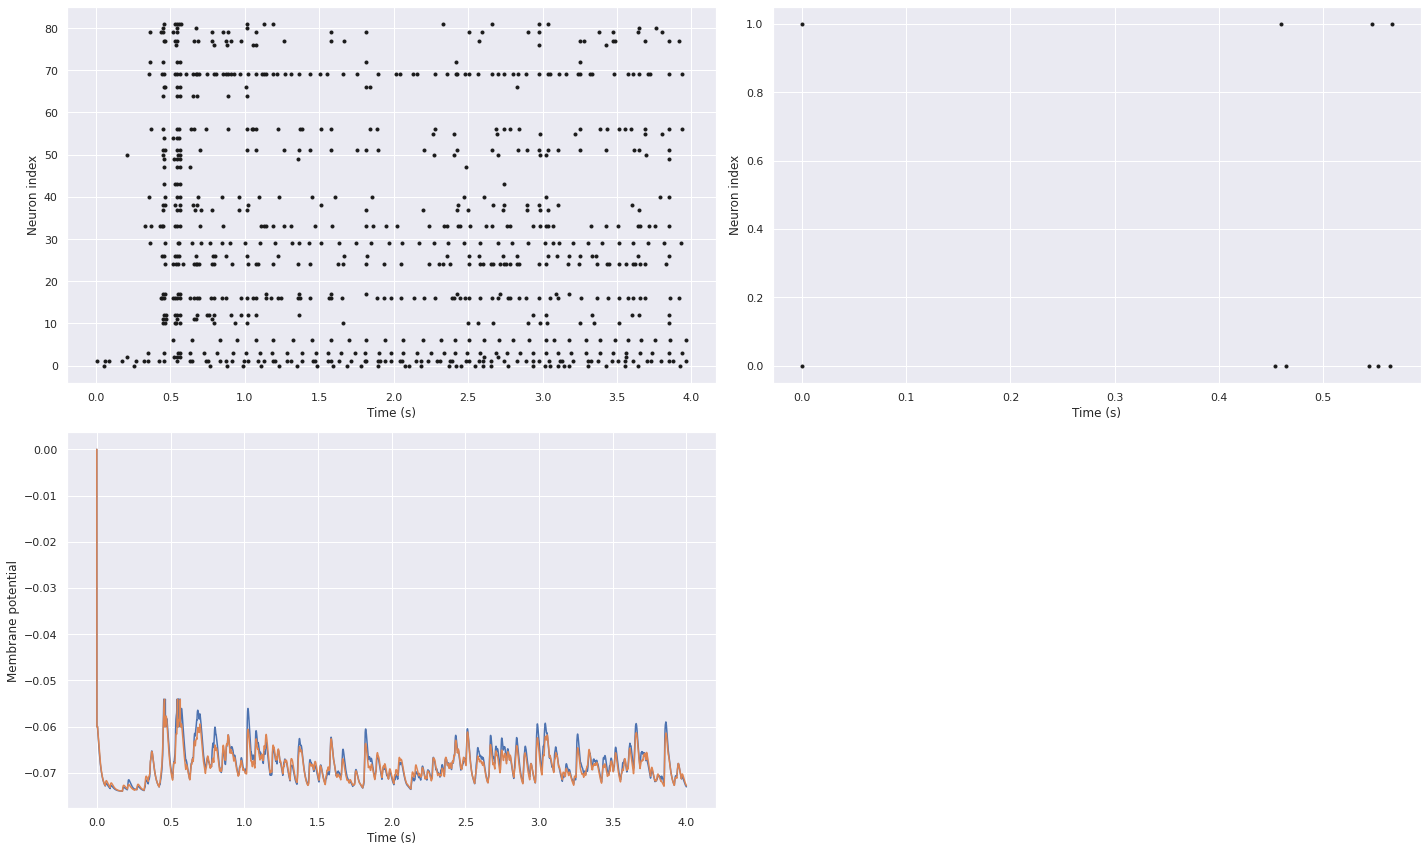

In [71]:
# Read EMG signal
emg_pr1_man = semg_bss.hyser.load_pr(
    DATA_DIR,
    task_type="maintenance",
    gesture=1,
    subject=1,
    session=1,
    task=1,
    trial=1,
    sig_type="preprocess"
)
# Extract MUAPTs
firings_pr1_man = emg_separator.transform(emg_pr1_man)
# Run simulation
n0.set_spikes(firings_pr1_man["MU index"].values, firings_pr1_man["Firing time"].values * second)
snn.run(4 * second)

print(f"Neuron0 spiked {np.count_nonzero(monitor1.i == 0)} times.")
print(f"Neuron1 spiked {np.count_nonzero(monitor1.i == 1)} times.")

plt.figure(figsize=(20, 12))

plt.subplot(221)
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.plot(monitor0.t / second, monitor0.i, ".k")

plt.subplot(222)
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.plot(monitor1.t / second, monitor1.i, ".k")

plt.subplot(223)
plt.xlabel("Time (s)")
plt.ylabel("Membrane potential")
plt.plot(monitor3.t / second, monitor3.V[0], label="Neuron 0")
plt.plot(monitor3.t / second, monitor3.V[1], label="Neuron 1")

plt.tight_layout()
plt.show()

Neuron0 spiked 1 times.
Neuron1 spiked 1 times.


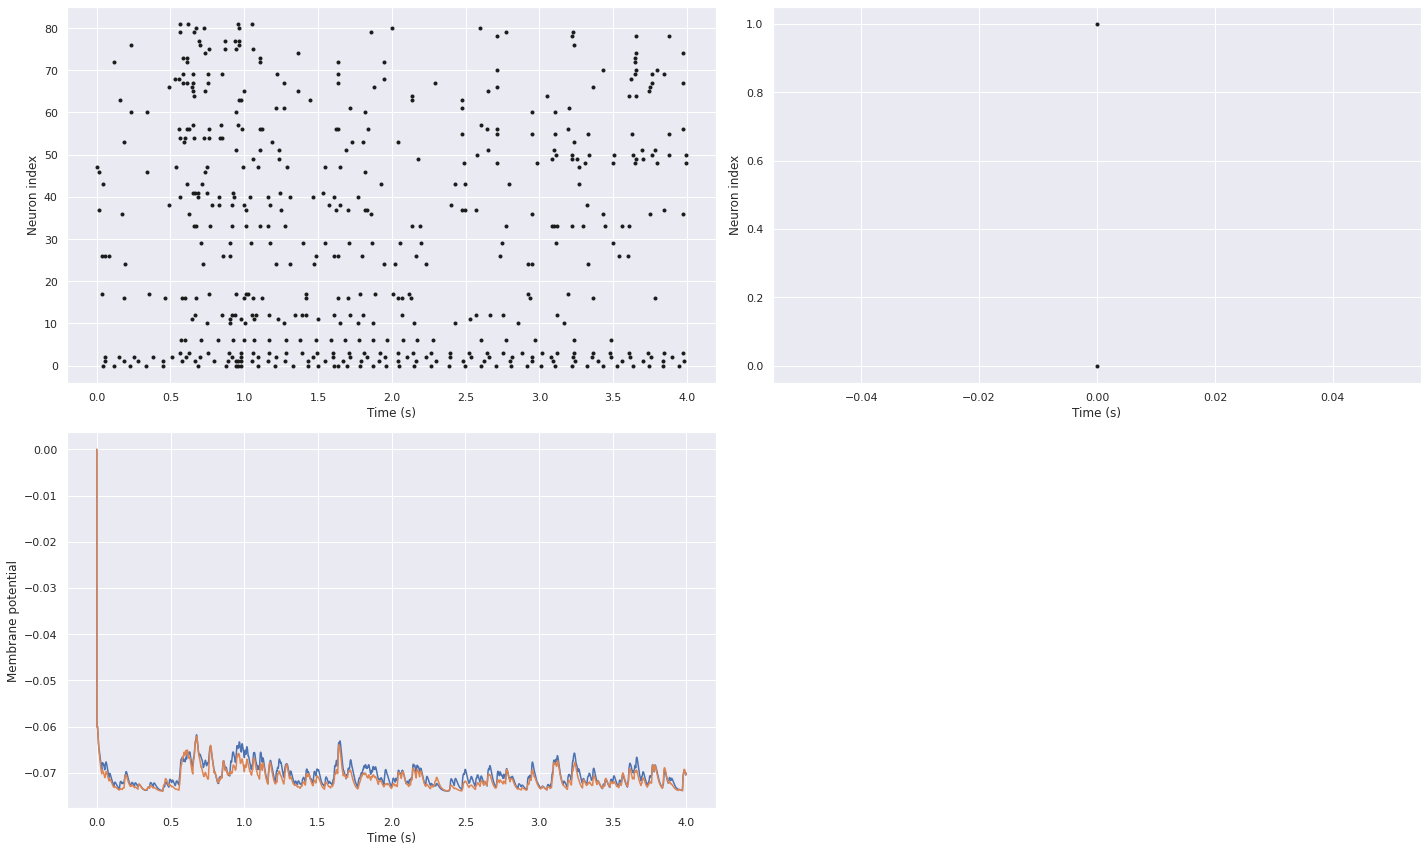

In [73]:
# Read EMG signal
emg_pr2_man = semg_bss.hyser.load_pr(
    DATA_DIR,
    task_type="maintenance",
    gesture=2,
    subject=1,
    session=1,
    task=1,
    trial=1,
    sig_type="preprocess"
)
# Extract MUAPTs
firings_pr2_man = emg_separator.transform(emg_pr2_man)
# Run simulation
n0.set_spikes(firings_pr2_man["MU index"].values, firings_pr2_man["Firing time"].values * second)
snn.run(4 * second)

print(f"Neuron0 spiked {np.count_nonzero(monitor1.i == 0)} times.")
print(f"Neuron1 spiked {np.count_nonzero(monitor1.i == 1)} times.")

plt.figure(figsize=(20, 12))

plt.subplot(221)
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.plot(monitor0.t / second, monitor0.i, ".k")

plt.subplot(222)
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.plot(monitor1.t / second, monitor1.i, ".k")

plt.subplot(223)
plt.xlabel("Time (s)")
plt.ylabel("Membrane potential")
plt.plot(monitor3.t / second, monitor3.V[0], label="Neuron 0")
plt.plot(monitor3.t / second, monitor3.V[1], label="Neuron 1")

plt.tight_layout()
plt.show()